#### Attempting Equation 3

Trying to 'hard code' Equation 3 from the Briel paper 


This code tries to calculate a rate for a specific transient event (Ia) for a certain metallicity (z020)

###### Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from pylab import cm
import numpy as np
import scipy.integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d

###### Data

In [2]:
path = "/Users/dillon/Desktop"
file = h5py.File(f"{path}/data.h5", "r")
DTD = file["DTD"]
SFH = file["SFH"]

In [3]:
event_types = ["Ia", "IIP", "II", "Ib", "Ic", "LGRB", "PISNe", "BBH", "BHNS", "BNS"]

In [4]:
metallicities = ["z001", "z002", "z003", "z004", "z006", "z008", "z010", "z014", "z020", "z030", "z040", "zem4", "zem5" ]

In [5]:
event_total = {}
for i in (metallicities):
    event_total[i] = {}
    for j in event_types:
        event_total[i][j] = DTD[j][i][:]
    event_total[i]["CCSN"] = event_total[i]["II"] + event_total[i]["Ib"] + event_total[i]["Ic"] + event_total[i]["IIP"]

In [6]:
Z1 = metallicities[8] 
Z2 = metallicities[0]

In [7]:
x1 = event_total[Z1]
x2 = event_total[Z2]

Checking DTD

(1e-15, 1e-11)

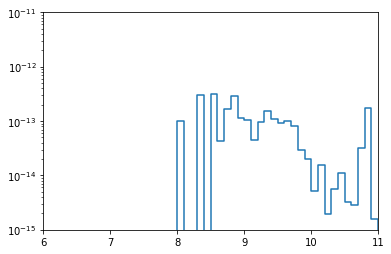

In [8]:
plt.step(file['DTD'].attrs['bin_centres'], x1["Ia"], where="post")
plt.yscale('log')
plt.xlim(6, 11)
plt.ylim(1e-15,1e-11)

##### DTD Integral

In [9]:
DTD = x1["Ia"]

bin_centres = file['DTD'].attrs['bin_centres']


def integrate_dtd(bin_start, bin_end):
    def integrand(t):
        return np.interp(t, bin_centres, DTD)
    
    result, _ = quad(integrand, bin_start, bin_end)
    return result


N = len(bin_centres)
integral_values = []

for j in range(N - 1):
    bin_start = 10 ** bin_centres[j]
    bin_end = 10 ** bin_centres[j + 1]
    
    
    integral = integrate_dtd(bin_start, bin_end)
    integral_values.append(integral)




In [10]:
print(integral_values)

[1.45302579171669e-10, 1.8292510931844796e-10, 2.3028906857621987e-10, 2.899167604890127e-10, 3.649835770846608e-10, 4.594871000794145e-10, 5.78459986681584e-10, 7.282379769395611e-10, 9.167972950027875e-10, 1.1541794121431616e-09, 1.4530257917166785e-09, 1.8292510931844646e-09, 2.3028906857621793e-09, 2.8991676048901033e-09, 3.6498357708465774e-09, 4.594871000794106e-09, 5.784599866815795e-09, 7.2823797693955504e-09, 9.167972950027803e-09, 1.1541794121431519e-08, 1.4530257917166667e-08, 1.8292510931844496e-08, 2.3028906857621604e-08, 2.8991676048900792e-08, 3.6498357708465476e-08, 4.59487100079407e-08, 5.784599866815746e-08, 7.282379769395494e-08, 9.167972950027725e-08, 1.1541794121431426e-07, 1.4530257917166552e-07, 1.8292510931844336e-07, 2.302890685762143e-07, 2.8991676048900535e-07, 3.649835770846519e-07, 4.5948710007940326e-07, 5.7845998668157e-07, 7.282379769395432e-07, 9.167972950027646e-07, 1.1541794121431333e-06, 1.4530257917166434e-06, 1.829251093184419e-06, 2.30289068576212

##### SFH Integral

In [11]:
tng_SFH = np.sum(SFH["TNG"], axis=0)
TNG_z = SFH['TNG'].attrs['redshift']

Checking SFH Plot

(0.0, 15.0)

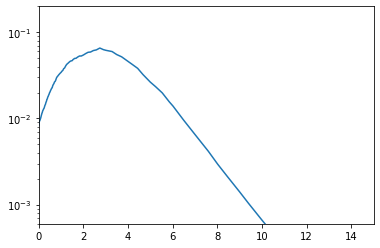

In [12]:
plt.plot(TNG_z, tng_SFH)
plt.yscale('log')
plt.ylim(6e-4,2e-1)
plt.xlim(0, 15)

In [13]:
@np.vectorize
def lookback(z, omega1, omega2, hubble):
    
    def f(x):
        a = np.sqrt(omega1*(1+x)**3 + omega2)
        return 1/((1+x)*a)
    t_hubble = (1/(100*hubble))*3.0856776*10**19
    return t_hubble *scipy.integrate.quad(f, 0, z)[0]/(60*60*24*365.2388526*1e9)

In [14]:
h = SFH.attrs['h']
omega_M = SFH.attrs['omega_M']
omega_L = SFH.attrs['omega_L']

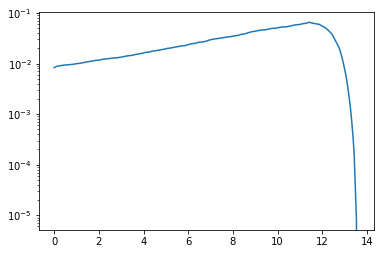

In [15]:
plt.plot(lookback(TNG_z, omega_M, omega_L, h), tng_SFH)
plt.yscale('log')

In [16]:
lb_TNG = lookback(TNG_z, omega_M, omega_L, h)

In [17]:
lb_TNG = np.array(lb_TNG)
tng_SFH = np.array(tng_SFH)

In [18]:
conversion = 1000000000
tng_SFH = tng_SFH * conversion

In [19]:
def integrate_tng_SFH(bin_start, bin_end):
    def integrand(t):
        tng_sfh_interp = interp_tng_SFH(np.log10(t))
        return np.interp(t, bin_centres, DTD) * tng_sfh_interp
    
    result, _ = quad(integrand, bin_start, bin_end)
    return result




interp_tng_SFH = interp1d(lb_TNG, tng_SFH, kind='linear', fill_value='extrapolate')


def integrand(t):
    tng_sfh_interp = interp_tng_SFH(np.log10(t))
    return np.interp(t, bin_centres, DTD) * tng_sfh_interp


N = len(bin_centres)
integral_values_sfh = []

for j in range(N - 1):
    bin_start = 10 ** bin_centres[j]
    bin_end = 10 ** bin_centres[j + 1]
    
    
    integral_sfh = integrate_tng_SFH(bin_start, bin_end)
    integral_values_sfh.append(integral_sfh)


print(integral_values_sfh)


[0.003497712363186841, 0.004500081325613866, 0.005760961052497002, 0.00737887920507045, 0.009549945280916029, 0.012236689405893826, 0.015573212320292528, 0.020012594768987518, 0.025923369120704934, 0.03374511185954625, 0.043550265754116184, 0.05583563700375604, 0.07132685240430095, 0.09125065128181174, 0.11678764872287013, 0.14931883565833695, 0.19091627979435957, 0.24404140775469796, 0.3114567817506939, 0.39828596088897955, 0.5116693965737876, 0.6538651918274517, 0.8386689140448592, 1.089343985181747, 1.3958216279202722, 1.7949963868112877, 2.336389035053452, 3.0305073146021826, 3.909117545643531, 5.0071981776803245, 6.422883282283481, 8.242881437447757, 10.565001218859111, 13.461342268631991, 17.06407720691642, 21.86283275827691, 28.192363736046197, 36.122966356993636, 45.73678912627273, 58.32971166033513, 75.00630573882664, 96.20417675913056, 122.28864947640298, 154.25138803710465, 197.23297498019605, 253.3792206723687, 326.7350019721567, 420.868346457128, 538.4165560182166, 682.420

###### Rates

In [20]:

def calculate_rate(bin_centres, DTD, lb_TNG, tng_SFH, interp_tng_SFH):
    N = len(bin_centres)
    rate_values = []

    for j in range(N):
        integral_dtd_j = integrate_dtd(bin_centres[j], bin_centres[-1])  
        bin_width = 10 ** bin_centres[j] - (10 ** bin_centres[j - 1] if j > 0 else 0)

        rate_j = 0
        for i in range(j + 1, N):
            integral_tng_sfh_i = integrate_tng_SFH(10 ** bin_centres[i - 1], 10 ** bin_centres[i])

            rate_j += integral_tng_sfh_i * integral_dtd_j / bin_width

        rate_values.append(rate_j)

    return rate_values


rate = calculate_rate(bin_centres, DTD, lb_TNG, tng_SFH, interp_tng_SFH)

print(rate)


[7.361141208822128e-16, 2.959455046994925e-15, 2.2588554133316127e-15, 1.88074609081852e-15, 1.4215819107385728e-15, 1.1434469467971693e-15, 9.551356962676969e-16, 7.283606539772337e-16, 6.153426436521259e-16, 4.628369831229192e-16, 3.9131477112981016e-16, 2.9394662143960473e-16, 2.4226602033904287e-16, 1.8665667118965134e-16, 1.5344379349911111e-16, 1.1932491918966375e-16, 9.178007640851448e-17, 7.275381666410116e-17, 5.76859579824566e-17, 4.649675473237158e-17, 3.586770529655555e-17, 2.779299260485773e-17, 2.236148028848753e-17, 1.6378256149792103e-17, 1.2226238085284842e-17, 9.064167371578331e-18, 6.477778292522983e-18, 4.75844490256857e-18, 3.223233932603597e-18, 2.1762767352860523e-18, 1.5653073345497584e-18, 1.1574944559732345e-18, 8.502251664445973e-19, 5.7192967613147e-19, 3.7364392384826457e-19, 2.50555892959647e-19, 1.615060449949468e-19, 9.909927551451582e-20, 6.473119307734679e-20, 4.581108797983111e-20, 3.4581071662869207e-20, 2.5531688398848648e-20, 1.9209822677785766e-20

Text(0, 0.5, 'Rate Density')

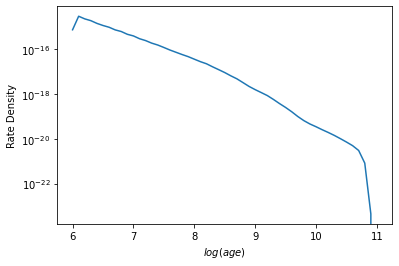

In [21]:
plt.plot(bin_centres, rate)
plt.yscale('log')
plt.xlabel('$log(age)$')
plt.ylabel('Rate Density')